__Figure 3, 4, and 5__

Required files: '../../results/"result names"/MM/rh_"risk measure"_copula_selection.csv' generated by run.ipynb; see result_names and risk_measures in the code below. 

In [67]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
sys.path.append('../../src/')
from toolbox import *

result_names = ['BBT_Tiingo',                #0
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',     #2
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',     #4
                'BBT_future_BITX',
                'BBT_future_BITW20',         #6
                'BBT_future_BITW70', 
                'BBT_future_BITW100',        #8
                'BBT_future_CRIX']

risk_measures = ['Variance',
                 'ES q=0.05', 'ES q=0.01',
                 'VaR q=0.05', 'VaR q=0.01',
                 'ERM k=10', 'CH']

order = ['BBT_Tiingo',    
         'BBT_future_CRIX', 'BBT_future_BITX', 'BBT_future_BITW100', 
         'BBT_future_BITW20',  'BBT_future_BITW70',
         'BBT_future_Tiingo_ada', 'BBT_future_Tiingo_eth',  'BBT_future_Tiingo_ltc','BBT_future_Tiingo_xrp']

coin_names = ['btc', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ada', 'eth', 'ltc', 'xrp']

new_coin_names = ['BTC', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ADA', 'ETH', 'LTC', 'XRP']

start = []
for n in range(len(order)):
    rn = order[n]
    rm = 'ES q=0.05'
    path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                    %(rn, rm)
    
    df = pd.read_csv(path)
    df.Date = pd.to_datetime(df.Date)
    
    start.append(np.min(df.Date))
    
start = np.max(start)

In [68]:
# Group rows by time difference
def removeDuplicate(x):
      return list(dict.fromkeys(x))

def groupRowsbyDiff(arr, thres, skip=True):
    # 
    # input : array to be grouped and threshold
    # output: a nested list of index
    
    outer = []
    group_id = []
    
    K = len(arr)
    for k in range(K):
        if k+1<K:
            if np.abs(arr[k] - arr[k+1])<=thres:
                group_id.append(k)
                group_id.append(k+1)

            elif len(group_id)==0:
                outer.append([k])

            else:
                if skip:
                    outer.append([group_id[0], group_id[-1]])
                else:
                    outer.append(group_id)
                group_id = []
                
        else:  # for the last row
            if len(group_id)==0:
                outer.append([k])
            else:
                outer.append(group_id)
                
    for i, o in enumerate(outer):
        outer[i] = removeDuplicate(o)
    return outer

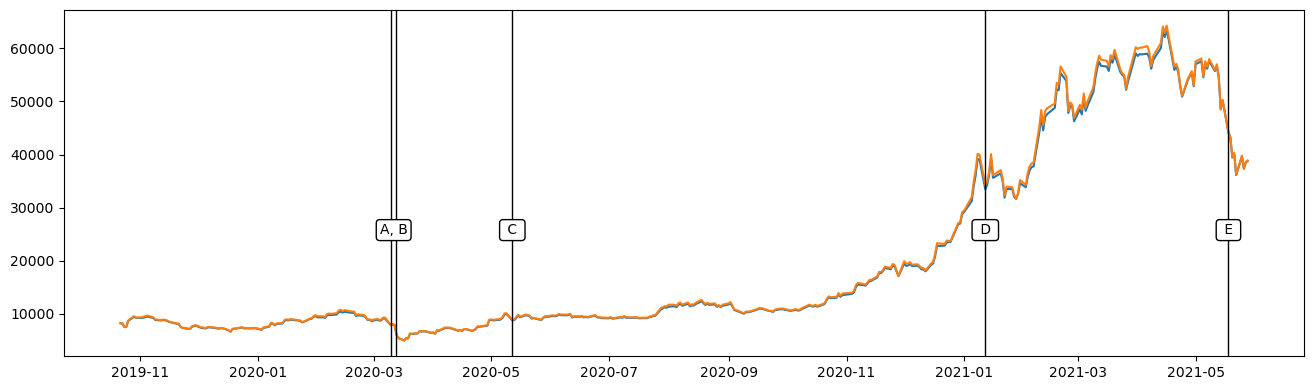

In [69]:
# Fugure 3
n = 0
rn = order[n]
rm = 'ES q=0.05'
path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)

df = pd.read_csv(path)
df.Date = pd.to_datetime(df.Date)

df = df.loc[df.Date > '2019-10-20']

# 11/3/2019 price: BTCF : 3835.0	BTC 3841.832104021910
# 18/10/2019 (one trading before 21/10/2019) 7990.0	BTCX19 Curncy	7943.626628985650
df = df.sort_values('Date')
df.loc[:,'rsc'] = np.exp(np.cumsum(df.rs))* 7943.626628985650
df.loc[:,'rfc'] = np.exp(np.cumsum(df.rf))* 7990.0	
df.loc[:,'rhc'] = np.cumsum(df.rh)

fig, ax = plt.subplots(figsize=(16,9/2),nrows=1, sharex=True)
ax.plot(df.Date, df.rsc)
ax.plot(df.Date, df.rfc)

N = 5

ABC = string.ascii_uppercase[:N][::-1]
rs_5min = df.sort_values('rs')[:N] 
rs_5min = rs_5min.sort_values('Date', ascending=False)
rs_5min = rs_5min.reset_index(drop=True)


# Group rows by time difference
K = len(rs_5min)
thres = datetime.timedelta(days=15)
outer = groupRowsbyDiff(rs_5min.Date, thres)

for k in range(N):
    ax.axvline(x=rs_5min.Date.iloc[k], color='black', linestyle='-', linewidth=1)


for o in outer:
    if len(o)==1:
        ax.text(rs_5min.loc[o[0] , 'Date'], 25000, ' '+ABC[o[0]]+' ',
                   ha='center', 
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))
        
    elif o[-1]-o[0]==1:
        t1 = rs_5min.loc[o[0] , 'Date'].value/10**9
        t2 = rs_5min.loc[o[-1] , 'Date'].value/10**9
        pos = datetime.datetime.fromtimestamp((t1+t2)/2)
           
        ax.text(pos, 25000,
                   ABC[o[-1]]+', '+ABC[o[0]],
                   ha='center', 
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
        
    else:
        t1 = rs_5min.loc[o[0] , 'Date'].value/10**9
        t2 = rs_5min.loc[o[-1] , 'Date'].value/10**9
        pos = datetime.datetime.fromtimestamp((t1+t2)/2)
           
        ax.text(pos, 25000,
                   ABC[o[-1]]+' - '+ABC[o[0]],
                   ha='center', 
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))


Text(0, 0.5, 'cumulative return')

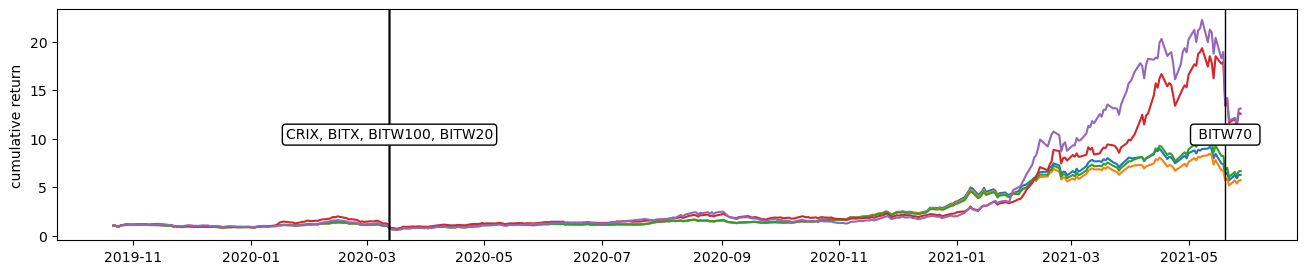

In [70]:
# figure 5
fig, ax = plt.subplots(figsize=(16,6/2),nrows=1, sharex=True)

for n in range(1,6):
    rn = order[n]
    rm = 'ES q=0.05'
    path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                    %(rn, rm)

    df = pd.read_csv(path)
    df.Date = pd.to_datetime(df.Date)

    # df = df.loc[df.Date >= start, :]
    df = df.loc[df.Date > '2019-10-20']

    # 11/3/2019 price: BTCF : 3835.0	BTC 3841.832104021910

    df = df.sort_values('Date')
    df.loc[:,'rsc'] = np.exp(np.cumsum(df.rs))
    df.loc[:,'rfc'] = np.exp(np.cumsum(df.rf))
    df.loc[:,'rhc'] = np.cumsum(df.rh)

    ax.plot(df.Date, df.rsc, label=order[n])
    
# plt.legend()

thres = datetime.timedelta(days=15)
outer = groupRowsbyDiff(rs_5min.Date, thres)

_min_rs_df = pd.DataFrame()

for n in range(1,6):
    rn = order[n]
    rm = 'ES q=0.05'
    path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                    %(rn, rm)

    df = pd.read_csv(path)
    df.Date = pd.to_datetime(df.Date)
    _min_rs = df.iloc[np.argmin(df.rs),:].copy()
    _min_rs.loc['coin'] = new_coin_names[n]
    _min_rs_df = _min_rs_df.append(_min_rs)
    ax.axvline(x=_min_rs.Date, color='black', linestyle='-', linewidth=1)
    
_min_rs_df = _min_rs_df.reset_index(drop=True)

outer = groupRowsbyDiff(_min_rs_df.Date, thres, skip=False)

yloc = 10
for o in outer:
    if len(o)==1:
        label = _min_rs_df.loc[o[0], 'coin']
        ax.text(_min_rs_df.loc[o[0] , 'Date'], yloc, ' '+label+' ',
                   ha='center', 
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))
        
    else:
        label_arr = [_min_rs_df.loc[o[i], 'coin'] for i in range(len(o))]
        t1 = _min_rs_df.loc[o[0] , 'Date'].value/10**9
        t2 = _min_rs_df.loc[o[-1] , 'Date'].value/10**9
        pos = datetime.datetime.fromtimestamp((t1+t2)/2)
           
        ax.text(pos, yloc,
                   ', '.join(label_arr),
                   ha='center', 
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))


ax.set_ylabel('cumulative return')
        
# plt.savefig('../../latex/_pics/index_price.pdf', transparent=True, bbox_inches='tight')
# plt.legend()

Text(0, 0.5, 'cumulative return')

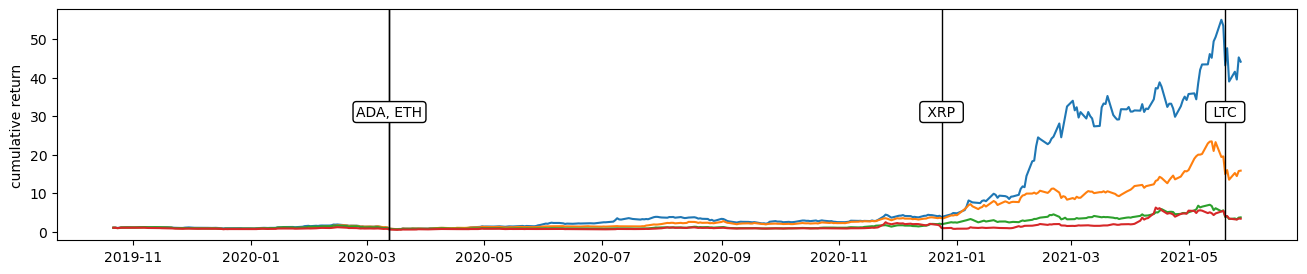

In [71]:
fig, ax = plt.subplots(figsize=(16,6/2),nrows=1, sharex=True)

for n in range(6,len(order)):
    rn = order[n]
    rm = 'ES q=0.05'
    path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                    %(rn, rm)

    df = pd.read_csv(path)
    df.Date = pd.to_datetime(df.Date)

    # df = df.loc[df.Date >= start, :]
    df = df.loc[df.Date > '2019-10-20']

    # 11/3/2019 price: BTCF : 3835.0	BTC 3841.832104021910

    df = df.sort_values('Date')
    df.loc[:,'rsc'] = np.exp(np.cumsum(df.rs))
    df.loc[:,'rfc'] = np.exp(np.cumsum(df.rf))
    df.loc[:,'rhc'] = np.cumsum(df.rh)

    ax.plot(df.Date, df.rsc, label=order[n])

# plt.legend()

thres = datetime.timedelta(days=15)
outer = groupRowsbyDiff(rs_5min.Date, thres)

_min_rs_df = pd.DataFrame()

for n in range(6,len(order)):
    rn = order[n]
    rm = 'ES q=0.05'
    path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                    %(rn, rm)

    df = pd.read_csv(path)
    df.Date = pd.to_datetime(df.Date)
    _min_rs = df.iloc[np.argmin(df.rs),:].copy()
    _min_rs.loc['coin'] = new_coin_names[n]
    _min_rs_df = _min_rs_df.append(_min_rs)
    ax.axvline(x=_min_rs.Date, color='black', linestyle='-', linewidth=1)
    
_min_rs_df = _min_rs_df.reset_index(drop=True)

yloc = 30
outer = groupRowsbyDiff(_min_rs_df.Date, thres, skip=False)

for o in outer:
    if len(o)==1:
        label = _min_rs_df.loc[o[0], 'coin']
        ax.text(_min_rs_df.loc[o[0] , 'Date'], yloc, ' '+label+' ',
                   ha='center', 
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))
        
    else:
        label_arr = [_min_rs_df.loc[o[i], 'coin'] for i in range(len(o))]
        t1 = _min_rs_df.loc[o[0] , 'Date'].value/10**9
        t2 = _min_rs_df.loc[o[-1] , 'Date'].value/10**9
        pos = datetime.datetime.fromtimestamp((t1+t2)/2)
           
        ax.text(pos, yloc,
                   ', '.join(label_arr),
                   ha='center', 
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))

ax.set_ylabel('cumulative return')
        
# plt.savefig('../../latex/_pics/individualCoins_price.pdf', transparent=True, bbox_inches='tight')

In [78]:
# Table 1
n  = 0 # btc
rn = order[n]
rm = 'ES q=0.01'
path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)

df = pd.read_csv(path)
df = df.loc[df.Date > '2019-10-20'] # out-of-sample
df = df.sort_values('rs').head().sort_values('Date')
df.loc[:,'drop_in_price'] = 1-np.exp(df.loc[:,'rs'])
df = df.loc[:,['Date','drop_in_price']]
df.index = list('ABCDE')
df

,Date,drop_in_price
A,2020-03-09 20:00:00+00:00,0.138304
B,2020-03-12 20:00:00+00:00,0.228922
C,2020-05-11 20:00:00+00:00,0.121071
D,2021-01-11 21:00:00+00:00,0.144081
E,2021-05-17 20:00:00+00:00,0.118638


In [73]:
# Table 2
for n in range(1,len(order)):
    rn = order[n]
    rm = 'ES q=0.01'
    path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                    %(rn, rm)
    df = df.loc[df.Date > '2019-10-20']
    df = pd.read_csv(path)

    print(coin_names[n], df.loc[df.rs.argmin(), 'Date'],  1-np.exp(df.loc[df.rs.argmin(), 'rs']))

CRIX 2020-03-12 20:00:00+00:00 0.2376768150844062
BITX 2020-03-12 20:00:00+00:00 0.23678809865997208
BITW100 2020-03-12 20:00:00+00:00 0.23867434356152906
BITW20 2020-03-12 20:00:00+00:00 0.2666202268190121
BITW70 2021-05-19 20:00:00+00:00 0.2763539066525593
ada 2020-03-12 20:00:00+00:00 0.23549572870825775
eth 2020-03-12 20:00:00+00:00 0.273955503434652
ltc 2021-05-19 20:00:00+00:00 0.3133378473692434
xrp 2020-12-23 21:00:00+00:00 0.4100116189744544
